# NGCC Baseline and Turndown

This notebook runs a series of net electric power outputs from 650 MW to 160 MW (about 100% to 25%) for an NGCC with 97% CO2 capture. The NGCC model is based on the NETL report "Cost and Performance Baseline for Fossil Energy Plants Volume 1: Bituminous Coal and Natural Gas to Electricity." Sept 2019, Case B31B (https://www.netl.doe.gov/projects/files/CostAndPerformanceBaselineForFossilEnergyPlantsVol1BitumCoalAndNGtoElectBBRRev4-1_092419.pdf).

## Imports

Import the modules that will be used.

In [1]:
import os
import numpy as np
import pandas as pd
from IPython.core.display import SVG
import pyomo.environ as pyo
import idaes
from idaes.core.solvers import use_idaes_solver_configuration_defaults
import idaes.core.util.scaling as iscale
import idaes.core.util as iutil
import ngcc
import pytest

## Make Output Directories

This notebook can produce a large number of output files.  To make it easier to manage, some subdirectories are used to organize output.  This ensures that the directories exist.

In [2]:
def make_directory(path):
    """Make a directory if it doesn't exist"""
    try:
        os.mkdir(path)
    except FileExistsError:
        pass
    
make_directory("data")
make_directory("data_pfds")
make_directory("data_tabulated")

## Global Solver Settings

Use the IDAES configuration system for solver settings. These will apply to all Ipopt instances created, including the ones created in initialization methods.

In [3]:
use_idaes_solver_configuration_defaults()
idaes.cfg.ipopt.options.nlp_scaling_method = "user-scaling"
idaes.cfg.ipopt.options.linear_solver = "ma57"
idaes.cfg.ipopt.options.OF_ma57_automatic_scaling = "yes"
idaes.cfg.ipopt.options.ma57_pivtol = 1e-5
idaes.cfg.ipopt.options.ma57_pivtolmax = 0.1
solver = pyo.SolverFactory("ipopt")

## Create the NGCC model

Create the NGCC model and initialize it or read the saved initialization if available.  The base initialized NGCC model is configured to match the baseline report with 90% capture using a Cansolv system.

In [4]:
m = pyo.ConcreteModel()
m.fs = ngcc.NgccFlowsheet(dynamic=False)
iscale.calculate_scaling_factors(m)
m.fs.initialize(
    load_from="ngcc_init.json.gz",
    save_to="ngcc_init.json.gz",
)
res = solver.solve(m, tee=True)

2022-11-16 15:10:41 [INFO] idaes.init.fs: NGCC load initial from ngcc_init.json.gz
Ipopt 3.13.2: nlp_scaling_method=user-scaling
tol=1e-06
linear_solver=ma57
ma57_pivtol=1e-05
ma57_pivtolmax=0.1
option_file_name=/var/folders/xf/4r1nvwm50_d1069gf048n6p80000gn/T/tmpbjjmwuty_ipopt.opt

Using option file "/var/folders/xf/4r1nvwm50_d1069gf048n6p80000gn/T/tmpbjjmwuty_ipopt.opt".


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version 

## Show PFDs with baseline results

This displays PFDs in the notebook, and saves them to files.  The full NGCC model is too big to show well in a single PFD, so it is broken into the three main sections, gas turbine, heat recovery steam generator (HRSG), and steam turbine.



Gas Turbine Section



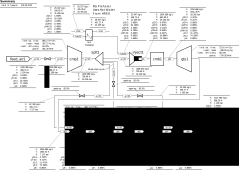



HRSG Section



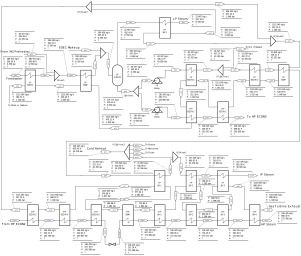



Steam Turbine Section



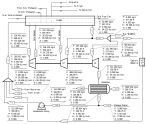

In [5]:
def display_pfd():
    print("\n\nGas Turbine Section\n")
    display(SVG(m.fs.gt.write_pfd()))
    print("\n\nHRSG Section\n")
    display(SVG(m.fs.hrsg.write_pfd()))
    print("\n\nSteam Turbine Section\n")
    display(SVG(m.fs.st.write_pfd()))

display_pfd()

m.fs.gt.write_pfd(fname="data_pfds/gt_baseline.svg")
m.fs.hrsg.write_pfd(fname="data_pfds/hrsg_baseline.svg")
m.fs.st.write_pfd(fname="data_pfds/st_baseline.svg")

## Test key model outputs against NETL baseline

In [6]:
#Assert results approximatly agree with baseline reoprt
assert pyo.value(m.fs.net_power_mw[0]) == pytest.approx(646)
assert pyo.value(m.fs.gross_power[0]) == pytest.approx(-690e6, rel=0.001)
assert pyo.value(100*m.fs.lhv_efficiency[0]) == pytest.approx(52.8, abs=0.1)
assert pyo.value(m.fs.total_variable_cost_rate[0]/m.fs.net_power_mw[0]) == pytest.approx(37.2799, rel=0.01)
assert pyo.value(m.fs.fuel_cost_rate[0]/m.fs.net_power_mw[0]) == pytest.approx(31.6462, rel=0.01)
assert pyo.value(m.fs.other_variable_cost_rate[0]/m.fs.net_power_mw[0]) == pytest.approx(5.63373, rel=0.01)
assert pyo.value(m.fs.gt.gt_power[0]) == pytest.approx(-477e6, rel=0.001)

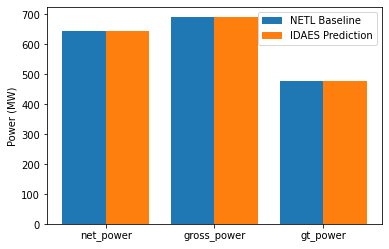

In [7]:
from matplotlib import pyplot as plt


variables=["net_power", "gross_power", "gt_power"]
netl_baseline = [646, 690, 477]
idaes_prediction = [pyo.value(m.fs.net_power_mw[0]), -pyo.value(m.fs.gross_power[0])*1e-6, -pyo.value(m.fs.gt.gt_power[0])*1e-6]

label_location = np.arange(len(variables))

width=0.4

fig, ax = plt.subplots()
netl_data = ax.bar(variables, netl_baseline, label="NETL Baseline")
idaes_sim = ax.bar(label_location + (width/2), idaes_prediction, width, label="IDAES Prediction")

ax.set_ylabel("Power (MW)")
ax.set_xticks(label_location)
ax.set_xticklabels(variables)
ax.legend()



## Run turndown cases 5 MW interval

Here we set the CO2 capture rate to 97% and set the specific reboiler duty to PZ advanced solvent system. The minimum power is 160 MW net, which corresponds to a bit under 25%.  This is roughly the minimum load for the NGCC modeled. Results are tabulated for tags in the tags_output tag group in a Pandas data frame. 

To run the series, change run_series to True.  Running the turndown series takes a while, unless previous saved results are available. 

In [8]:
run_series=False
if run_series:
    idaes.cfg.ipopt.options.tol = 1e-6
    idaes.cfg.ipopt.options.max_iter = 50
    solver = pyo.SolverFactory("ipopt")

    m.fs.cap_specific_reboiler_duty.fix(2.4e6)
    m.fs.cap_fraction.fix(0.97)
    powers = np.linspace(650, 160, int((650 - 160)/5) + 1)
    powers = list(powers)
    powers.insert(1, 646)

    df = pd.DataFrame(columns=m.fs.tags_output.table_heading())

    for p in powers:
        print("Simulation for net power = ",p)
        fname = f"data/ngcc_{int(p)}.json.gz"
        if os.path.exists(fname):
            iutil.from_json(m, fname=fname, wts=iutil.StoreSpec(suffix=False))
        else:
            m.fs.net_power_mw.fix(p)
            res = solver.solve(m, tee=False, symbolic_solver_labels=True)
            if not pyo.check_optimal_termination(res):
                break
            iutil.to_json(m, fname=fname)
        df.loc[m.fs.tags_output["net_power"].value] = m.fs.tags_output.table_row(numeric=True)
        if abs(p - 650) < 0.1:
            m.fs.gt.streams_dataframe().to_csv("data_tabulated/ngcc_stream_650mw_gt.csv")
            m.fs.st.steam_streams_dataframe().to_csv("data_tabulated/ngcc_stream_650mw_st.csv")
            m.fs.hrsg.steam_streams_dataframe().to_csv("data_tabulated/ngcc_stream_650mw_hrsg_steam.csv")
            m.fs.hrsg.flue_gas_streams_dataframe().to_csv("data_tabulated/ngcc_stream_650mw_hrsg_gas.csv")
    df.to_csv("data_tabulated/ngcc.csv")
        
    # Display the results from the run stored in a pandas dataframe
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    display(df)
    
    # Plot results
    plt.plot(df["net_power (MW)"], df["lhv_efficiency (%)"])
    plt.grid()
    plt.xlabel("Net Power (MW)")
    plt.ylabel("LHV Efficiency (%)")
    plt.title("Net Power vs. Efficiency")
    plt.show()

In [9]:
"""
jac, nlp = iscale.get_jacobian(m, scaled=True)
print("Extreme Jacobian entries:")
for i in iscale.extreme_jacobian_entries(jac=jac, nlp=nlp, large=100):
    print(f"    {i[0]:.2e}, [{i[1]}, {i[2]}]")
print("Badly scaled variables:")
for v, sv in iscale.badly_scaled_var_generator(
    m, large=1e2, small=1e-2, zero=1e-12
):
    print(f"    {v} -- {sv} -- {iscale.get_scaling_factor(v)}")
print(f"Jacobian Condition Number: {iscale.jacobian_cond(jac=jac):.2e}")
"""

'\njac, nlp = iscale.get_jacobian(m, scaled=True)\nprint("Extreme Jacobian entries:")\nfor i in iscale.extreme_jacobian_entries(jac=jac, nlp=nlp, large=100):\n    print(f"    {i[0]:.2e}, [{i[1]}, {i[2]}]")\nprint("Badly scaled variables:")\nfor v, sv in iscale.badly_scaled_var_generator(\n    m, large=1e2, small=1e-2, zero=1e-12\n):\n    print(f"    {v} -- {sv} -- {iscale.get_scaling_factor(v)}")\nprint(f"Jacobian Condition Number: {iscale.jacobian_cond(jac=jac):.2e}")\n'